# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

#### $\textit{- Análise de sentimento utilizando como base de dados as avaliações de filmes encontradas no site do IMDb. Uso do modelo Doc2Vec. }$
#### $\textit{Autor: Victor Rocha da Silva - PMR3508-2020-177}$

## Importando bibliotecas e dados
- Primeiramente, vamos importar algumas bibliotecas que serão úteis ao trabalhar com esses dados e, logo em seguida, o dataset:

Precisamos instalar algumas bibliotecas que serão importantes no decorrer do notebook: ftfy (Fixes Text For You), que corrige alguns erros de transcrição do Unicode; e gensim, importante em trabalhos relacionados a Natural Language Processing. Finalmente, vamos instalar também tensorflow e keras, responsáveis por algumas redes neurais.

In [1]:
!pip install --upgrade pip
!pip install ftfy
!pip install gensim
!pip install tensorflow
!pip install keras

     |████████████████████████████████| 1.5 MB 1.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
     |████████████████████████████████| 64 kB 680 kB/s 
  Created wheel for ftfy: filename=ftfy-5.8-py3-none-any.whl size=45612 sha256=dc2addb8ead014c1182ddd1309f0f6b4f1d61a5e1911ed3e4ee0bf4d9d63b793
  Stored in directory: /root/.cache/pip/wheels/49/1c/fc/8b19700f939810cd8fd9495ae34934b246279791288eda1c31
Successfully built ftfy


In [2]:
#Para o uso geral
import random
import numpy as np
import pandas as pd
import copy 
import time
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
import requests
import io
random.seed(36)

#Para o processamento de textos
from ftfy import fix_text
import string
import re
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec

#Importando funcionalidades do Scikit-Learn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Importando funcionalidades do Tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense
from tensorflow.python.framework import ops
from tensorflow.keras.callbacks import EarlyStopping

#Mede o progresso quando se está dentro de um laço
from tqdm import tqdm as tqdm

### Importando base de dados:

In [3]:
train = pd.read_csv("../input/sentiment-analysis-pmr3508/data_train.csv")

- Aqui temos uma representação de um trecho do dataset e de como ele se estrutura:

In [4]:
print('Formato do Dataset:', train.shape)

Formato do Dataset: (24984, 2)


In [5]:
train.head()

,review,positive
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


Nossos dados estão divididos em uma coluna "review", que apresenta as avaliações de vários filmes, e uma coluna "positive", que indica se a avaliação foi positiva ou não. Queremos predizer a variável "positive" com base no texto da avaliação.

## Preparação de dados

- Vamos fazer algumas modificações e limpezas nos textos que utilizaremos para analisar o sentimento

### Remoção de duplicatas
- O primeiro passo essencial é remover os dados duplicados no nosso dataset de avaliações, pois não é lógico imaginar que duas pessoas tenham tido exatamente a mesma avaliação do filme e com as mesmas palavras:

In [6]:
train = train.drop_duplicates(keep='first')
train.shape

(24888, 2)

Percebemos que quase 100 avaliações repetidas foram removidas.

### Desbalanceamento
- Podemos ver a distribuição dos sentimentos na nossa base de teste:

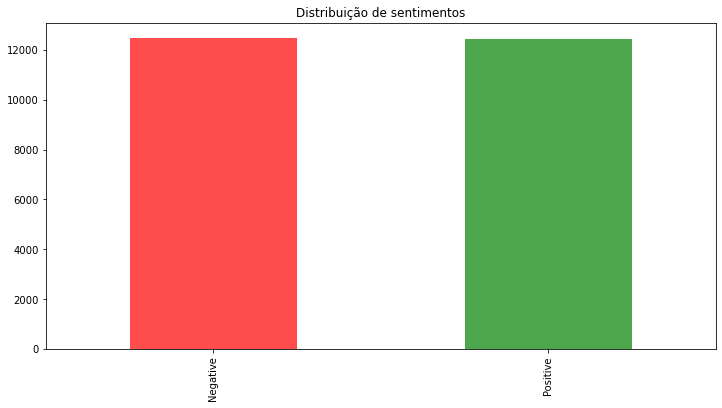

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
train.positive.value_counts().plot(kind='bar', ax = ax, color=['red', 'green'], alpha=0.7)
labels = ['Negative', 'Positive']
ax.set_xticklabels(labels)
ax.set_title('Distribuição de sentimentos')
plt.show()

Percebemos que não temos problemas de desbalanceamento nos dados, o que facilita o treinamento do modelo.

### Dados faltantes
- Precisamos verificar se temos dados faltantes:

In [8]:
train.isnull().sum()

review      0
positive    0
dtype: int64

Não há dados faltantes, o que simplifica nossa preparação de dados.

Podemos, agora, dividir nossos dados de treino em X(texto) e Y(rótulo):

In [9]:
X_train = train['review']
Y_train = train['positive']

### Limpeza e pré-processamento de dados
- Agora, vamos definir uma função para organizar o nosso texto e fazer uma limpeza em caracteres e pontuações indesejadas, além de passar todo o texto para letra minúscula. A função a seguir será copiada do notebook  "Introdução ao Doc2Vec"  fornecido (Créditos para Felipe Maia polo):

In [10]:
def clean(text):
    txt=text.replace("<br />"," ") #retirando tags
    txt=fix_text(txt) #consertando Mojibakes (Ver https://pypi.org/project/ftfy/)
    txt=txt.lower() #passando tudo para minúsculo
    txt=txt.translate(str.maketrans('', '', string.punctuation)) #retirando toda pontuação
    txt=txt.replace(" — ", " ") #retirando hífens
    txt=re.sub("\d+", ' <number> ', txt) #colocando um token especial para os números
    txt=re.sub(' +', ' ', txt) #deletando espaços extras
    return txt

- Aplicando a limpeza nos nossos textos da base de teste:

In [11]:
X_train.head()

0    Bromwell High is a cartoon comedy. It ran at t...
1    Homelessness (or Houselessness as George Carli...
2    Brilliant over-acting by Lesley Ann Warren. Be...
3    This is easily the most underrated film inn th...
4    This is not the typical Mel Brooks film. It wa...
Name: review, dtype: object

In [12]:
X_train = X_train.apply(clean)

In [13]:
X_train.head()

0    bromwell high is a cartoon comedy it ran at th...
1    homelessness or houselessness as george carlin...
2    brilliant overacting by lesley ann warren best...
3    this is easily the most underrated film inn th...
4    this is not the typical mel brooks film it was...
Name: review, dtype: object

### Tokenização dos textos

- Vamos, então, tokenizar os textos, tranformando cada avaliação(texto) em um vetor de palavras.

In [14]:
X_train = X_train.apply(lambda phrase: phrase.split())
X_train.head

<bound method NDFrame.head of 0        [bromwell, high, is, a, cartoon, comedy, it, r...
1        [homelessness, or, houselessness, as, george, ...
2        [brilliant, overacting, by, lesley, ann, warre...
3        [this, is, easily, the, most, underrated, film...
4        [this, is, not, the, typical, mel, brooks, fil...
                               ...                        
24979    [towards, the, end, of, the, movie, i, felt, i...
24980    [this, is, the, kind, of, movie, that, my, ene...
24981    [i, saw, descent, last, night, at, the, stockh...
24982    [some, films, that, you, pick, up, for, a, pou...
24983    [this, is, one, of, the, dumbest, films, ive, ...
Name: review, Length: 24888, dtype: object>

## Treino e aplicação do modelo Doc2Vec

- Feita a limpeza dos textos, podemos processá-lo com o modelo Doc2Vec, sendo que esse modelo de embedding converte cada uma das nossas análises em vetores "numéricos" já de um mesmo tamanho, alterando sua representação de forma a tornar a predição muito mais fácil. Para isso, precisamos importar o modelo Doc2Vec pré-treinado.

In [15]:
d2v = Doc2Vec.load("../input/sentiment-analysis-pmr3508/doc2vec")

- Para a aplicação do **embedding** modelo na nossa base de dados, utilizaremos a função disponibilizada no notebook de referência (Felipe Maia Polo):

In [16]:
def emb(txt, model, normalize=False): 
    model.random.seed(42)
    x=model.infer_vector(txt, steps=20)
    
    if normalize: return(x/np.sqrt(x@x))
    else: return(x)

Antes de aplicar nos nossos textos, precisamos transformar nosso X_train em uma lista. Em seguida, basta utilizar a função definida acima:

In [17]:
#Passando o dataset para lista
X_train = X_train.to_list()

#Aplicando a função
X_train = [emb(x, d2v) for x in X_train] 
X_train = np.array(X_train)

In [18]:
X_train.shape

(24888, 50)

In [19]:
X_train

array([[-0.18215555,  0.0839314 , -0.82176876, ...,  0.46831018,
         0.67071396,  0.03461775],
       [ 0.45688832,  0.18072858, -1.7777513 , ...,  0.13382944,
        -0.02281002,  1.4376358 ],
       [-0.5297115 ,  0.5718761 ,  0.374979  , ..., -0.06649754,
         0.71145123,  0.00474193],
       ...,
       [-1.2499707 , -0.7048726 , -0.55053234, ..., -0.15983972,
        -0.1156728 , -0.30150646],
       [-0.18022293,  0.14282005, -0.313455  , ...,  0.48528382,
        -0.08451959, -0.16396528],
       [-0.992572  ,  0.48401216, -0.12663089, ..., -0.25588062,
         0.4841671 ,  0.12823385]], dtype=float32)

Agora, conseguimos notar que cada avaliação de filme é dada por uma representação númerica (um vetor que armazena 50 valores). Esse números serão utilizados para buscar similaridade entre as palavras e decidir se a avaliação é mais positiva ou negativa.

## Dados de teste
- De acordo com o notebook de referência, é recomendado que a função de limpeza utilizada no do modelo de representação, ou seja, no Doc2Vec, seja idêntica à utilizada no treinamento do modelo de representação. Assim, iremos aplicar os mesmos exatos passos no set de teste:

In [20]:
# Importando os dados de teste
val = pd.read_csv("../input/sentiment-analysis-pmr3508/data_test1.csv")

# Dividindo o dataset
X_val = val["review"]
Y_val = val["positive"]

# Aplicação da limpeza e pré-processamento
X_val = X_val.apply(clean)
X_val = X_val.apply(lambda x: x.split())

# Aplicação do embedding
X_val = X_val.to_list()
X_val = [emb(x, d2v) for x in X_val] 
X_val = np.array(X_val)

O resultado obtido é o mesmo do conjunto de treino:

In [21]:
X_val

array([[-1.6221144 , -0.7478406 , -0.41051403, ..., -0.5644162 ,
         0.36998114,  0.24354668],
       [-0.42435348,  0.17226201, -0.8129823 , ...,  1.335386  ,
        -0.36954218, -0.9552513 ],
       [-1.2036512 ,  1.5038751 , -1.1739222 , ..., -0.635223  ,
        -0.8770969 ,  0.41741407],
       ...,
       [ 0.19926983, -0.02359951, -0.01505094, ...,  0.20906529,
         0.83229554,  0.04228503],
       [-0.73111254,  0.0387092 , -0.3073405 , ..., -0.05040532,
         1.0691316 , -0.7216944 ],
       [-0.2703734 , -0.84299713,  0.31448197, ...,  0.06219134,
        -0.8032088 ,  0.58844364]], dtype=float32)

## Redes neurais
- Adiante, como pedido na tarefa, iremos criar e treinar duas redes neurais para a tarefa de classificação, otimizando os hiperparâmetros: quantidade de neurônios na *hidden layer*, seu coeficiente de regularização e o tipo da taxa de aprendizado com o *RandomizedSearchCV*. A primeira rede neural apresentará uma *hidden layer* e a segunda, duas *hidden layers*. Para criar as redes, utilizaremos as bibliotecas Scikit-Learn e TensorFlow:

Obs.: A métrica utilizada será a AUC, a área embaixo do gráfico da curva ROC.

### Rede Neural com 1 Camada Oculta (Scikit-Learn)
- Utilizaremos o pacote *MLPClassifier* da biblioteca *Scikit-Learn*, com a opção early_stopping ativada, que finaliza o treinamento quando já não há melhoria da acurácia, evitando que ocorra overfitting:

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform as sp_loguniform

mlp_1l = MLPClassifier(random_state=40, early_stopping=True)

# Hiperparâmetros a serem otimizados
hyperparams = {'hidden_layer_sizes': [(2 ** i) for i in np.arange(6, 10)],
               'alpha': sp_loguniform(0.000001, 0.1),
               'learning_rate': ['constant','adaptive']}

# Busca de Hiperparâmetros
mlp_clf_1l = RandomizedSearchCV(mlp_1l, hyperparams, scoring='roc_auc', n_iter=25, cv=2, n_jobs=-1, random_state=0, verbose=2)
search_mlp1l = mlp_clf_1l.fit(X_train, Y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.5s finished


In [23]:
print("Melhores parâmetros: ", search_mlp1l.best_params_); print("Melhor score: ", search_mlp1l.best_score_)

Melhores parâmetros:  {'alpha': 2.1027036109989297e-05, 'hidden_layer_sizes': 512, 'learning_rate': 'constant'}
Melhor score:  0.8885971135321222


### Rede Neural com 2 Camadas Oculta (Scikit-Learn)
- Também iremos utilizar o pacote *MLPClassifier* da biblioteca *Scikit-Learn*, mas agora com uma *hidden_layer* a mais:

In [24]:
mlp_2l = MLPClassifier(random_state=40, early_stopping=True)

# Hiperparâmetros a serem otimizados
hyperparams = {'hidden_layer_sizes': [(2 ** i, 2 ** j) for j in np.arange(6, 10) for i in np.arange(6, 10)],
               'alpha': sp_loguniform(0.000001, 0.1),
               'learning_rate': ['constant','adaptive']}

# Busca de Hiperparâmetros
mlp_clf_2l = RandomizedSearchCV(mlp_2l, hyperparams, scoring='roc_auc', n_iter=25, cv=2, n_jobs=-1, random_state=0, verbose=2)
search_mlp2l = mlp_clf_2l.fit(X_train, Y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


In [25]:
print("Melhores parâmetros: ", search_mlp2l.best_params_); print("Melhor score: ", search_mlp2l.best_score_)

Melhores parâmetros:  {'alpha': 5.209144886889889e-06, 'hidden_layer_sizes': (512, 512), 'learning_rate': 'constant'}
Melhor score:  0.8895870214708199


### Rede Neural com 2 Camadas Oculta (TensorFlow)
- Iremos criar uma outra rede neural com 2 *hidden_layers*, mas dessa vez vamos utilizar a biblioteca TensorFlow e Keras, seguindo as instruções fornecidas no notebook de referência (Felipe Maia Polo). 
- As estratégias de regularização que utilizaremos neste exemplo são de dois tipos: restrições para valores dos pesos da rede, com uma mistura das penalizações dos tipos  l1  e  l2  ('Elastic Net'), e early stopping. Logo, teremos quatro hiperparâmetros para otimizar: os hiperparâmetros das estratégias de regularização e o número de neurônios nas duas camadas ocultas. Em relação ao early stopping, vamos fixar que se a métrica AUC (ROC) não melhorar em 40 iterações seguidas no conjunto de teste, o treinamento é interrompido, assim como nas duas primeiras redes.
- Para fazer a escolha dos melhores valores, utilizaremos a abordagem da busca aleatória (Random Search). Vamos então criar um dataframe com n_iter combinações aleatórias para os hiperparâmetros (tirando o número de iterações) e que testaremos a seguir:

In [26]:
n_iter=100

neurons=[]
pen=[]

#Sorteando valores
for i in range(n_iter):
    n1=random.randrange(25, 100, 1)
    n2=random.randrange(20, n1, 1)
    neurons.append((n1, n2))
    
    l1=random.choice([0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1e-1])
    l2=random.choice([0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1e-1])
    pen.append((l1, l2))

- Agora, vamos criar um dataframe com as combinações obtidas por meio do sorteio:

In [27]:
params = {'neurons': neurons, 'penalties': pen, 'iterations': n_iter*[None], 'auc': n_iter*[None]}
params = pd.DataFrame(params)
params = params[["neurons", "penalties", "iterations", "auc"]]

params.head()

,neurons,penalties,iterations,auc
0,"(61, 25)","(0, 0.001)",None,None
1,"(47, 27)","(1e-10, 0.01)",None,None
2,"(80, 43)","(0.001, 1e-10)",None,None
3,"(94, 29)","(0.001, 1e-05)",None,None
4,"(87, 69)","(1e-10, 0.1)",None,None


- Note que cada elemento da coluna 'neurons' é uma tupla, que na primeira entrada nos dá o número de neurônios na primeira camada oculta e na segunda entrada nos dá o número de neurônios na segunda camada oculta. Por outro lado, cada elemento da coluna 'penalties' é uma tupla, que na primeira entrada nos dá o valor referente à regularização  l1  e na segunda entrada nos dá o valor referente à regularização  l2 .
- Na coluna 'iterations' vamos guardar o número de iterações realizadas (por conta do early stopping) e na coluna 'auc' vamos guardar a AUC (ROC) estimada no conjunto de validação.

- Abaixo vamos criar uma função que cria modelos de redes neurais do Keras prontos para serem treinados, o que facilitará na hora de fazer a otimização dos hiperparâmetros:

In [28]:
def create_model(neurons=(10,10), pen=(.001, .001)):
    
    ops.reset_default_graph() #é importante resetar os grafos das redes neurais já criadas para não tornam o processo muito lento 
    
    #Criando modelo
    model = Sequential()
    model.add(Dense(neurons[0], input_shape=(n_features,), activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l1=pen[0], l2=pen[1]), 
                    bias_regularizer=regularizers.l1_l2(l1=pen[0], l2=pen[1])))
    model.add(Dense(neurons[1], activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l1=pen[0], l2=pen[1]), 
                    bias_regularizer=regularizers.l1_l2(l1=pen[0], l2=pen[1])))
    model.add(Dense(1, activation='sigmoid', 
                    kernel_regularizer=regularizers.l1_l2(l1=pen[0], l2=pen[1]), 
                    bias_regularizer=regularizers.l1_l2(l1=pen[0], l2=pen[1])))
    
    #Compilando
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    return model

- Para cada linha do dataframe 'params', vamos treinar um modelo e avaliá-lo no conjunto de teste:

In [29]:
n_features = X_train.shape[1]
es = EarlyStopping(monitor = "val_auc", patience = 10)

for i in tqdm(range(n_iter)):
    model = create_model(params.loc[i, "neurons"], params.loc[i, "penalties"])
    
    history = model.fit(X_train, Y_train, epochs = 50, validation_data = (X_val, Y_val), 
                        batch_size = 96, shuffle = True, verbose = False, callbacks = [es]) 
    
    params.loc[i, "iterations"] = len(history.history["val_auc"])
    params.loc[i, "auc"] = history.history["val_auc"][-1]

100%|██████████| 100/100 [11:58<00:00,  7.18s/it]


- Vamos visualizar as 10 melhores combinações de valores para os hiperparâmetros:

In [30]:
# Define o dataframe de tal modo que as métricas AUC apareçam em ordem decrescente, apenas para facilitar a visualização
params = params.sort_values("auc", ascending = False)
params.head()

,neurons,penalties,iterations,auc
47,"(92, 22)","(0, 0.001)",11,0.894599
73,"(95, 28)","(1e-15, 0.001)",11,0.894002
20,"(69, 51)","(1e-15, 0.001)",11,0.893576
39,"(64, 27)","(1e-05, 0.001)",11,0.893406
77,"(47, 33)","(1e-10, 0.001)",11,0.893095


- Vamos treinar nosso modelo final com os melhores valores para os hiperparâmetros e o melhor número de iterações:

In [31]:
#Melhores valores
neurons = params["neurons"][0]
pen = params["penalties"][0]
epochs = params["iterations"][0]

#Criando modelo
model_optimized = create_model(neurons, pen)

#Treinando modelo
model_optimized.fit(X_train, Y_train, epochs = epochs, validation_data = (X_val, Y_val), 
                        batch_size = 96, shuffle = True, verbose = 1)

Epoch 1/11
260/260 [==============================] - 1s 3ms/step - loss: 0.5548 - auc: 0.8572 - val_loss: 0.4954 - val_auc: 0.8866
Epoch 2/11
260/260 [==============================] - 1s 2ms/step - loss: 0.4766 - auc: 0.8922 - val_loss: 0.4775 - val_auc: 0.8892
Epoch 3/11
260/260 [==============================] - 1s 2ms/step - loss: 0.4587 - auc: 0.8956 - val_loss: 0.4625 - val_auc: 0.8914
Epoch 4/11
260/260 [==============================] - 1s 2ms/step - loss: 0.4468 - auc: 0.8982 - val_loss: 0.4554 - val_auc: 0.8927
Epoch 5/11
260/260 [==============================] - 1s 2ms/step - loss: 0.4400 - auc: 0.8994 - val_loss: 0.4529 - val_auc: 0.8914
Epoch 6/11
260/260 [==============================] - 1s 2ms/step - loss: 0.4337 - auc: 0.9011 - val_loss: 0.4487 - val_auc: 0.8922
Epoch 7/11
260/260 [==============================] - 1s 2ms/step - loss: 0.4286 - auc: 0.9028 - val_loss: 0.4484 - val_auc: 0.8916
Epoch 8/11
260/260 [==============================] - 1s 2ms/step - loss: 0.

- O resultado obtido para essa rede neural foi:

In [32]:
print("Melhor score: ", roc_auc_score(Y_val, model_optimized.predict(X_val.squeeze())))

Melhor score:  0.8933033018914358


## Modelos alternativos
- Nessa etapa, iremos criar alguns modelos alternativos de predição dentre os aprendidos em aula, comparando suas acurácias com as das redes neurais:

### KNN (K-Nearest Neighbors)
- Vamos definir o KNN e encontrar os melhores hiperparâmetros utilizando o método GridSearchCV. Buscaremos o hiperparâmetro "K" ótimo no intervalo de 3 a 35.

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm = "auto", leaf_size = 30, n_jobs = -1)

grid_params_knn = {"p":[1, 2], "n_neighbors":[i for i in range(3, 36)]}
grid_knn = GridSearchCV(knn, grid_params_knn, cv = 2, n_jobs = -1, verbose = 1, scoring = "roc_auc")

- Tendo encontrado os melhores hiperparâmetros, podemos treinar nosso KNN:

In [34]:
grid_knn.fit(X_train, Y_train)

Fitting 2 folds for each of 66 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed: 20.4min finished


GridSearchCV(cv=2, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, 32, ...],
                         'p': [1, 2]},
             scoring='roc_auc', verbose=1)

- Vamos avaliar nosso KNN usando o *scorer* do próprio *GridSearchCV*, que foi utilizado durante a otimização dos hiperparâmetros:

In [35]:
print("Hiperparâmetros:", grid_knn.best_estimator_)
print("Melhor score:", grid_knn.best_score_)

Hiperparâmetros: KNeighborsClassifier(n_jobs=-1, n_neighbors=35)
Melhor score: 0.8506492032314856


- Mantendo o melhor modelo encontrado para o KNN:

In [36]:
knn = grid_knn.best_estimator_

### Regressão Logística
- Vamos testar a regressão logística com o resultado do Doc2Vec. Para fazer a busca de hiperparâmetros, utilizaremos o RandomizedSearchCV, otimizando os valores de C e do tipo de regularização:

In [37]:
from sklearn.linear_model import LogisticRegression

# Modelo de Regressão Logística
logreg = LogisticRegression(solver='liblinear',random_state=42)

# Hiperparâmetros a serem otimizados: 'C' e tipo de regularização
hyperparams = dict(C=np.linspace(0,10,100), 
                   penalty=['l2', 'l1'])

# Busca de Hiperparâmetros
logreg_clf = RandomizedSearchCV(logreg, hyperparams, scoring='roc_auc', n_iter=50, cv=2, n_jobs=-1, random_state=0, verbose=2)
search_logreg = logreg_clf.fit(X_train, Y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.0s finished


- Os melhores hiperparâmetros encontrados e a melhor acurácia nesse regressor foram:

In [38]:
print("Hiperparâmetros:", search_logreg.best_params_)
print("Melhor score:", search_logreg.best_score_)

Hiperparâmetros: {'penalty': 'l2', 'C': 0.20202020202020202}
Melhor score: 0.8826467548609556


## Comparação entre todos os modelos utilizados
- Adiante, iremos comparar as acurácias dos nossos 5 modelos e determinar qual é o melhor. O modelo com melhor resultado será usado na predição final:

In [39]:
modelos = ['NN_SKLearn_1L', 'NN_SKLearn_2L', 'NN_TensorFlow_2L', 'KNN', 'LogisticRegression']
scores = [search_mlp1l.best_score_, search_mlp2l.best_score_, roc_auc_score(Y_val, model_optimized.predict(X_val).squeeze()), 
          grid_knn.best_score_, search_logreg.best_score_]
comparação = {'Modelo': modelos, "AUC": scores}
comparação = pd.DataFrame(comparação)

- Vamos organizar a nossa tabela em ordem decrescente de AUC:

In [40]:
comparação = comparação.sort_values("AUC", ascending = False)
comparação.reset_index(drop=True, inplace=True)
comparação.head()

,Modelo,AUC
0,NN_TensorFlow_2L,0.893303
1,NN_SKLearn_2L,0.889587
2,NN_SKLearn_1L,0.888597
3,LogisticRegression,0.882647
4,KNN,0.850649


- Percebemos que o modelo que resultou numa melhor métrica AUC foi a Rede Neural com duas *hidden layers* feita utilizando Tensor Flow e Keras. Portanto, utilizaremos ela para realizar a predição.

## Análise de sentimento 
- Para finalizar, precisamos predizer os sentimentos na nossa base de dados teste 2, em que temos apenas as avaliações e fazer sua submissão. Começamos importando-a:

In [41]:
test = pd.read_csv("../input/sentiment-analysis-pmr3508/data_test2_X.csv")
test.head()

,review
0,"How is it in this day and era, people are stil..."
1,"I mean let's face it, all you have to do in mo..."
2,"""RVAM""'s reputation preceded it. I first heard..."
3,A lot of the negative reviews here concentrate...
4,A SOUND OF THUNDER. One of the greatest short ...


### Limpeza e pré-processamento dos dados de teste
- Trataremos os dados de teste da mesma maneira como fizemos com o set de treino:

In [42]:
X_test = test['review'].tolist()
X_test = [clean(x).split() for x in X_test]
X_test = [emb(x, d2v) for x in X_test] 
X_test = np.array(X_test)

### Predição
- Realizando a predição e passando-a para o formato .csv:

In [43]:
predict = {"positive":model_optimized.predict(X_test).squeeze()}
submission = pd.DataFrame(predict)
submission.to_csv("submission.csv", index = True, index_label = "Id")


In [44]:
submission.head()

,positive
0,0.001514
1,0.338344
2,0.009116
3,0.090361
4,0.029743


E finalmente conseguimos obter a nossa predição!!!